In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

import torchvision as tv
from torchvision import datasets, models, transforms

import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

import time
import os
import copy
import requests
import io
import csv

plt.ion()   # interactive mode

import timm 
from tqdm import tqdm

In [ ]:
# Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(3 * 224 * 224, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, 3 * 224 * 224)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.encoder(x))
        x = torch.sigmoid(self.decoder(x))
        x = x.view(x.size(0), 3, 224, 224)
        return x

In [65]:
# Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3 * 224 * 224, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 3 * 224 * 224),
            nn.Sigmoid()
        )
 
 
    def forward(self, x):
        batchsz = x.size(0)
        # flatten
        x = x.view(batchsz, -1)
        # encoder
        x = self.encoder(x)
        # decoder
        x = self.decoder(x)
        # reshape
        x = x.view(batchsz, 3, 224, 224)
        
        return x  

In [2]:
# Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3 * 224 * 224, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 3 * 224 * 224),
            nn.Sigmoid()
        )
 
 
    def forward(self, x):
        batchsz = x.size(0)
        # flatten
        x = x.view(batchsz, -1)
        # encoder
        x = self.encoder(x)
        # decoder
        x = self.decoder(x)
        # reshape
        x = x.view(batchsz, 3, 224, 224)
        
        return x  

In [3]:
# class CAE(nn.Module):
#     def __init__(self, encoding_dim, hidden_dim):
#         super(CAE, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv2d(3, hidden_dim, 3, stride=1, padding=1),  # b, 16, 10, 10
#             nn.ReLU(True),
#             nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
#             nn.Conv2d(hidden_dim, encoding_dim, 3, stride=1, padding=1),  # b, 8, 3, 3
#             nn.ReLU(True),
#             nn.MaxPool2d(2, stride=2)  # b, 8, 2, 2
#         )
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(encoding_dim, hidden_dim, 3, stride=2, padding=1, output_padding=1),  # b, 16, 5, 5
#             nn.ReLU(True),
#             nn.ConvTranspose2d(hidden_dim, 224, 3, stride=2, padding=1, output_padding=1),  # b, 8, 15, 15
#             nn.ReLU(True),
#             nn.ConvTranspose2d(224, 3, 3, stride=1, padding=1),  # b, 1, 28, 28
#             nn.Tanh()
#         )
 
#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)


In [4]:
# # check the flow of the structure
# net = nn.Sequential(
#     nn.Conv2d(3, 128, 3, stride=1, padding=1), nn.ReLU(True), nn.MaxPool2d(2, stride=2),
#     nn.Conv2d(128, 32, 3, stride=1, padding=1), nn.ReLU(True), nn.MaxPool2d(2, stride=2),
#     nn.ConvTranspose2d(32, 128, 3, stride=2, padding=1, output_padding=1), nn.ReLU(True),
#     nn.ConvTranspose2d(128, 224, 3, stride=2, padding=1, output_padding=1), nn.ReLU(True),
#     nn.ConvTranspose2d(224, 3, 3, stride=1, padding=1), nn.Tanh())

# X = torch.rand(size=(1,3,224,224), dtype=torch.float32)
# for layer in net:
#     print(layer.__class__.__name__,'output shape: \t',X.shape)
#     X = layer(X)

In [5]:
# Check if CUDA (GPU support) is available
is_cuda_available = torch.cuda.is_available()
print("Is CUDA (GPU) available:", is_cuda_available)

# If CUDA is available, print the GPU name(s)
if is_cuda_available:
    gpu_count = torch.cuda.device_count()
    print(f"Number of GPU(s) available: {gpu_count}")
    for i in range(gpu_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available. Using CPU.")

Is CUDA (GPU) available: True
Number of GPU(s) available: 1
GPU 0: Quadro RTX 6000


In [6]:
from timm.data import create_dataset, create_loader

In [7]:
# config 
input_size = 3, 224, 224
img_size = 224
num_classes = 15
batch_size = 128

input_dim = 3 * 224 * 224 
hidden_dim = 128
latent_dim = 32
learning_rate = 0.001     # 学习率
num_epochs = 50     # 迭代次数

interpolation = 'bicubic'
DEFAULT_CROP_PCT = 1

train_dir = '../Dataset/images/train'
val_dir = '../Dataset/images/validation'

class_map = {
        'Normal': 0,
        'Atelectasis': 1,
        'Cardiomegaly': 2,
        'Effusion': 3,
        'Infiltration': 4,
        'Mass': 5,
        'Nodule': 6,
        'Pneumonia': 7,
        'Pneumothorax': 8,
        'Consolidation': 9,
        'Edema': 10,
        'Emphysema': 11,
        'Fibrosis': 12,
        'Pleural_Thickening': 13,
        'Hernia': 14,
        }

In [8]:
# create the train and eval datasets
train_dataset = create_dataset(name='', root=train_dir, split='train', is_training=True, batch_size=batch_size, class_map = class_map)
val_dataset = create_dataset(name='', root=val_dir, split='validation', is_training=False, batch_size=batch_size, class_map = class_map)
train_len, val_len = len(train_dataset), len(val_dataset)
print('Training set size: ' + str(train_len))
print('Validation set size: ' + str(val_len))

Training set size: 91295
Validation set size: 13175


In [9]:
# resize images to fit the input of pretrained model
transform = transforms.Compose([
    #transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [10]:
train_dataset.transform = transform
val_dataset.transform = transform

In [11]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

In [12]:
# create data loaders 
train_loader = create_loader(
        train_dataset,
        input_size=input_size,
        batch_size=batch_size,
        is_training=True,
        interpolation=interpolation,
        num_workers=8,
        pin_memory=True)

val_loader = create_loader(
        val_dataset,
        input_size=input_size,
        batch_size=batch_size,
        is_training=False,
        interpolation=interpolation,
        num_workers=8,
        pin_memory=True,
        crop_pct=DEFAULT_CROP_PCT)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device) # if print 'cuda' then GPU is used

cuda


In [67]:
autoencoder = Autoencoder(latent_dim,hidden_dim).to(device)

In [68]:
#autoencoder = CAE(latent_dim,hidden_dim).to(device)

In [69]:
# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    # Move model to GPU
    autoencoder.cuda()

    # Move data tensors to GPU
    #data_tensor = data_tensor.cuda()

    # Check the device of model parameters
    for name, param in autoencoder.named_parameters():
        print(f"Parameter {name} is on device: {param.device}")

    # Check the device of data tensor
    print(f"train_loader is on device: {train_loader.device}")
    print(f"val_loader is on device: {val_loader.device}")

else:
    print("CUDA (GPU) is not available.")


Parameter encoder.0.weight is on device: cuda:0
Parameter encoder.0.bias is on device: cuda:0
Parameter encoder.2.weight is on device: cuda:0
Parameter encoder.2.bias is on device: cuda:0
Parameter decoder.0.weight is on device: cuda:0
Parameter decoder.0.bias is on device: cuda:0
Parameter decoder.2.weight is on device: cuda:0
Parameter decoder.2.bias is on device: cuda:0
train_loader is on device: cuda
val_loader is on device: cuda


In [70]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

In [71]:
from datetime import datetime
current_datetime = datetime.now()
date_time = str(current_datetime)[:-7].replace('-','').replace(':','').replace(' ','_')
model_name = 'Autoencoder_3Layer'
#model_name = 'CAE'

In [72]:
def output_log_writer(s, end='\r'):
    with open(f'model_result/log/output_{model_name}_{date_time}.txt', 'a') as output_file:
        output_file.write(s+'\n')
        print(s,end,flush=True)

In [ ]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    output_log_writer(f'-------------------------------[Epoch {epoch+1}]---------------------------------')
    output_log_writer(f'[Epoch {epoch+1}] Training...', end='')
    autoencoder.train()
    running_loss = 0.0
    for images, _ in train_loader:
        print('=', end='')
        images = images.to(device)
        optimizer.zero_grad()
        outputs = autoencoder(images)
        
        #output_log_writer(f'[Epoch {epoch+1}] Computing Train Loss...')
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_train = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {loss_train}")
    
    # save model checkpoint
    ckpt_save_path = f'model_result/model_checkpoint/MODEL_CKPT_{epoch}_{model_name}_{date_time}.pt'
    torch.save({
            'epoch': epoch,
            'model_state_dict': autoencoder.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_train,
            }, ckpt_save_path)
    output_log_writer(f'[Epoch {epoch+1}] Model checkpoint is saved.')

# Save model
torch.save(autoencoder, f'model_result/model_pth/MODEL_{model_name}_{date_time}.pth')
print('Autoencoder training complete.')

-------------------------------[Epoch 1]--------------------------------- 
[Epoch 1] Training... 
=========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================Epoch 1, Loss: 1.2654297880170053
[Epoch 1] Model checkpoint is saved. 
-------------------------------[Epoch 2]--------------------------------- 
[Epoch 2] Training... 
===================

# load model

In [73]:
autoencoder_loaded = Autoencoder(latent_dim,hidden_dim).to(device)
optimizer_loaded = optim.Adam(autoencoder.parameters(), lr=learning_rate)

In [74]:
ckpt_save_path = 'model_result/model_checkpoint/Autoencoder_deeper/MODEL_CKPT_9_Autoencoder_2Layers_20240423_022224.pt'

In [75]:
checkpoint = torch.load(ckpt_save_path)

In [76]:
autoencoder_loaded.load_state_dict(checkpoint['model_state_dict'])
optimizer_loaded.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [77]:
autoencoder_loaded.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=150528, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=150528, bias=True)
    (3): Sigmoid()
  )
)

# load test set to visualise the reconstruction

In [78]:
batch_size = 3

In [79]:
test_dir = '../Dataset/images/test'
test_dataset = create_dataset(name='', root=test_dir, split='validation', is_training=False, batch_size=batch_size, class_map = class_map)
test_len = len(test_dataset)
print('Training set size: ' + str(test_len))

Training set size: 37067


In [80]:
test_dataset.transform = transform
test_loader = create_loader(
        test_dataset,
        input_size=input_size,
        batch_size=batch_size,
        is_training=False,
        interpolation=interpolation,
        num_workers=8,
        pin_memory=True,
        crop_pct=DEFAULT_CROP_PCT)

In [81]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

In [82]:
images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = autoencoder_loaded(images_flatten)

In [83]:
# prep images for display
images = images.cpu().numpy()

In [84]:
# output is resized into a batch of images
output = output.view(batch_size, 3, 224, 224)
# use detach when it's an output that requires_grad
output = output.cpu().detach().numpy()

In [85]:
images.shape

(3, 3, 224, 224)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


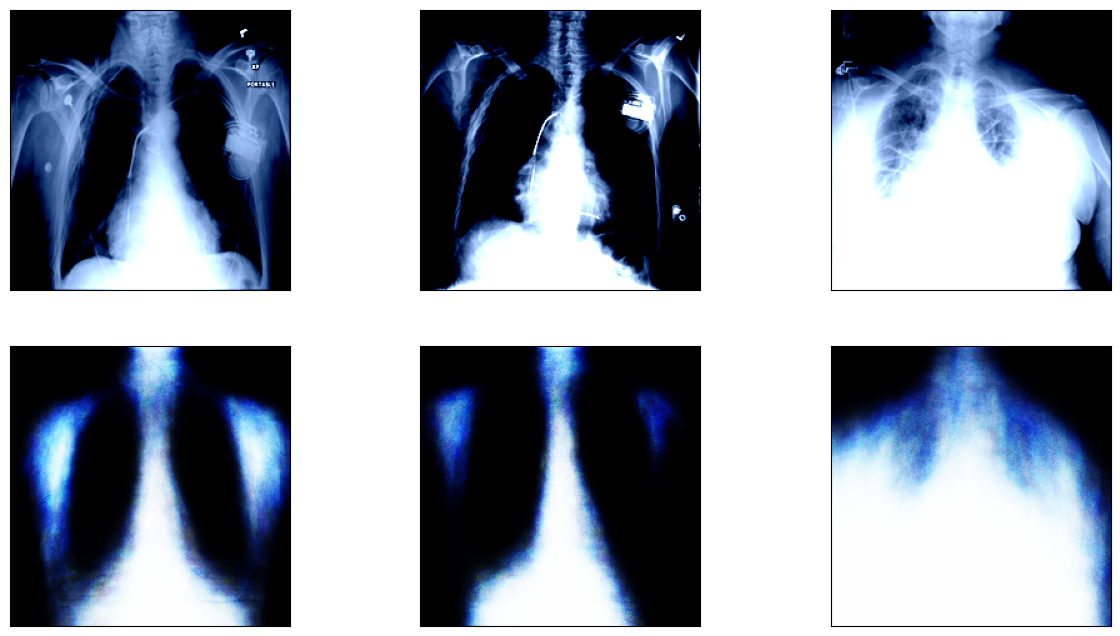

In [86]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(15,8))
# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        img_transposed = np.transpose(img, (1, 2, 0))
        ax.imshow(np.squeeze(img_transposed), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)